# Modeling

The goal will be to select the best regression model between OLS, Ridge, and Random Forest to predict housing prices.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/Users/dennisfrancis/Desktop/Data/house_prices_preprocessed.csv')

In [3]:
df.head()

,Unnamed: 0,SalePrice,YearBuilt_normalized,YearRemodAdd_normalized,BsmtFinSF1_normalized,BsmtUnfSF_normalized,TotalBsmtSF_normalized,1stFlrSF_normalized,2ndFlrSF_normalized,WoodDeckSF_normalized,...,D_ConLw,D_New,D_Oth,D_WD,D_Abnorml,D_AdjLand,D_Alloca,D_Family,D_Normal,D_Partial
0,0,208500,0.949275,0.883333,0.125089,0.064212,0.140098,0.119780,0.413559,0.000000,...,0,0,0,1,0,0,0,0,1,0
1,1,181500,0.753623,0.433333,0.173281,0.121575,0.206547,0.212942,0.000000,0.347725,...,0,0,0,1,0,0,0,0,1,0
2,2,223500,0.934783,0.866667,0.086109,0.185788,0.150573,0.134465,0.419370,0.000000,...,0,0,0,1,0,0,0,0,1,0
3,3,140000,0.311594,0.333333,0.038271,0.231164,0.123732,0.143873,0.366102,0.000000,...,0,0,0,1,1,0,0,0,0,0
4,4,250000,0.927536,0.833333,0.116052,0.209760,0.187398,0.186095,0.509927,0.224037,...,0,0,0,1,0,0,0,0,1,0


In [4]:
df.columns

Index(['Unnamed: 0', 'SalePrice', 'YearBuilt_normalized',
       'YearRemodAdd_normalized', 'BsmtFinSF1_normalized',
       'BsmtUnfSF_normalized', 'TotalBsmtSF_normalized', '1stFlrSF_normalized',
       '2ndFlrSF_normalized', 'WoodDeckSF_normalized',
       ...
       'D_ConLw', 'D_New', 'D_Oth', 'D_WD', 'D_Abnorml', 'D_AdjLand',
       'D_Alloca', 'D_Family', 'D_Normal', 'D_Partial'],
      dtype='object', length=213)

In [15]:
y.shape
X.shape

(1460, 211)

In [17]:
X = df.drop(['Unnamed: 0', 'SalePrice'], axis=1).values
y = df['SalePrice'].values

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.3, random_state=42)

## OLS Linear Regression

In [18]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
reg.score(X_test, y_test)

-8868553842821034.0

In [19]:
mean_squared_error(y_test, y_pred, squared=False)

7866740127851.165

#### Outrageous results. 

OLS Regression is giving outrageasly horrible results. An R-squared value of -8868553842821034.0 and a mean squared of error 7866740127851.165 do not make sense given the context of what we are trying to accomplish here, predict housing prices in the range of 200000 to 800000. On to random forest.

## Random Forest

In [70]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {rf_model.score(X_test, y_test)}")

Root Mean Squared Error: 25836.927783181756
R-squared: 0.9043367916593468


#### This is a much better result.

Compared to the OLS linear regression, these results are much more palpable. RMSE of 25,836 given that the majority of our housing prices we are trying to predict range from 150000 all the way to 600000k shown in the histogram below. Perhaps random forest, as expected is the best model for us, however, I am going to explore and see if there is some middle ground with Regularized Regression

<Axes: >

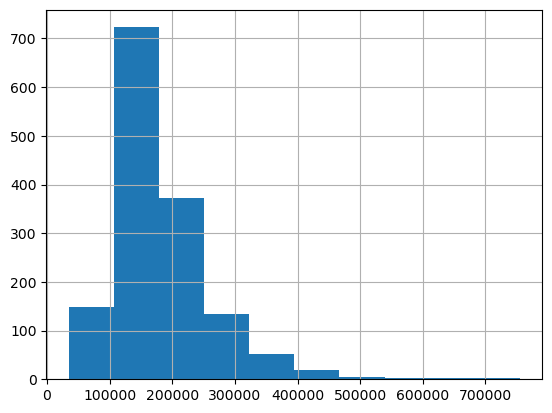

In [30]:
df['SalePrice'].hist()

## Regularized Regression

In [33]:
scores = {}
for alpha in [0.1, 1.0, 10.0, 100.0, 1000.0]:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    scores[alpha] = ridge.score(X_test, y_test)
print(scores)

{0.1: 0.8885492786513514, 1.0: 0.8826922462637675, 10.0: 0.8714814788105874, 100.0: 0.8442996892642903, 1000.0: 0.7605555112222694}


In [35]:
alpha

1000.0

Text(0.5, 0, 'alpha ridge hyperparameter')

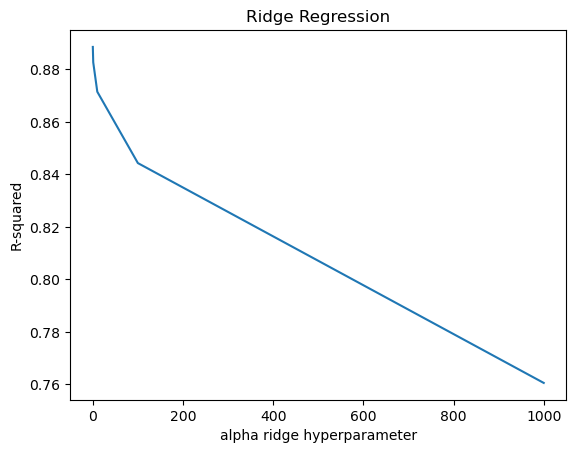

In [40]:
plt.plot([0.1, 1.0, 10.0, 100.0, 1000.0], scores.values())
plt.ylabel('R-squared')
plt.title('Ridge Regression')
plt.xlabel('alpha ridge hyperparameter')

#### Ridge Regression alpha hyperparameter of 0.1 gives R-squared of .88

This is great, but not better than the .9 R-squared we saw for Random Forest Regression

## Cross Validation

The goal will be to use 6 fold CV to see what model performs better: Random Forest Regression or Ridge Regression. I will also be doing Grid Search CV for hyperparemeter tuning. 

In [44]:
kf = KFold(n_splits = 5, shuffle=True, random_state=42)
param_grid = {'alpha':np.arange(0.0001, 1, 10), 'solver':['sag', 'lsqr']}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid, cv=kf)
ridge_cv.fit(X_train, y_train)
print(ridge_cv.best_params_, ridge_cv.best_score_)

/Users/dennisfrancis/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dennisfrancis/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dennisfrancis/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dennisfrancis/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dennisfrancis/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'alpha': 0.0001, 'solver': 'sag'} 0.7539317346555153


/Users/dennisfrancis/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### The model didn't converge, I will adjust the range and play with different values for max_iter

In [63]:
kf = KFold(n_splits = 5, shuffle=True, random_state=42)
param_grid = {'alpha':np.arange(0.0001, .3, 10), 'solver':['sag', 'lsqr']}
ridge = Ridge(max_iter=10)
ridge_cv = GridSearchCV(ridge, param_grid, cv=kf)
ridge_cv.fit(X_train, y_train)
print(ridge_cv.best_params_, ridge_cv.best_score_)

{'alpha': 0.0001, 'solver': 'sag'} 0.805730746638335


/Users/dennisfrancis/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dennisfrancis/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dennisfrancis/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dennisfrancis/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dennisfrancis/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dennisfrancis/anac

#### running the above cell numerous times, alpha of 0.0001 remains the best.

In [66]:
ridge = Ridge(alpha=0.0001)
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

0.8877903189177282

### CV on Random Forest Regression and Ridge Regression

#### Random Forest

In [71]:
kf = KFold(n_splits=10, shuffle=True)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
cv_results = cross_val_score(rf_model, X, y, cv=kf)
print(cv_results)
print(np.mean(cv_results), np.std(cv_results))
print(np.quantile(cv_results, [0.025, .975]))

[0.85492552 0.89729032 0.77147012 0.68956155 0.90357771 0.92769762
 0.90447249 0.93808053 0.87998408 0.89437137]
0.8661431307760343 0.07352744726808691
[0.70799097 0.93574437]


#### Ridge 

In [72]:
kf = KFold(n_splits=10, shuffle=True)
ridge = Ridge(alpha=0.0001)
cv_results = cross_val_score(ridge, X, y, cv=kf)
print(cv_results)
print(np.mean(cv_results), np.std(cv_results))
print(np.quantile(cv_results, [0.025, .975]))

[0.84000122 0.90715199 0.87963974 0.68586908 0.87791303 0.88194908
 0.80409172 0.33869202 0.89773    0.85892895]
0.7971966830322322 0.16462171254321648
[0.41680685 0.90503204]


## Results

It was nice to have a go with the ridge regression model. It achieved useful results with an average score of 0.79 in 10 fold cross validation. In the end, as expected the random forest regression wins, with an average r-squared score of 0.86 with 10-fold cross validation. This must be due to the size of the data set and it is mostly dummy variables or categorical data, with strange columns like "front porch screened square footage" and "paved basement square footage." The OLS regression model performed extremely poorly.